# Abstract

The purpose of this notebook is to help troubleshoot the development of new backends. It provides visuals comparing the main operators with the numpy reference implementation.

In [1]:
from ptychocg import PtychoCuFFT
from tike.ptycho._core.numpy import PtychoNumPyFFT

import numpy as xp
import lzma
import pickle

import matplotlib.pyplot as plt

In [2]:
testdir = "./"
dataset_file = os.path.join('./data/ptycho_setup.pickle.lzma')
if not os.path.isfile(dataset_file):
    create_dataset(dataset_file)
with lzma.open(dataset_file, 'rb') as file:
    [
        data,
        scan,
        probe,
        original,
    ] = [xp.array(x) for x in pickle.load(file)]

In [3]:
print(data.shape)
print(scan.shape)
print(probe.shape)
print(original.shape)

(1, 169, 30, 30)
(1, 169, 2)
(1, 15, 15)
(1, 128, 128)


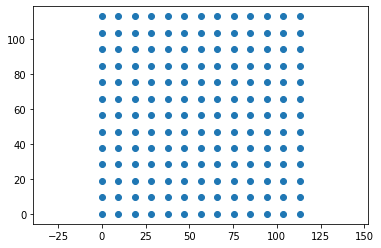

In [4]:
plt.figure()
plt.scatter(scan[0, :, 0], scan[0, :, 1])
plt.xlim(0, 128)
plt.ylim(0, 128)
plt.axis('equal')
plt.show()

In [5]:
with PtychoNumPyFFT(
            nscan=scan.shape[-2],
            probe_shape=probe.shape[-1],
            detector_shape=data.shape[-1],
            nz=original.shape[-2],
            n=original.shape[-1],
            ntheta=scan.shape[0],
) as slv:
    t1 = slv.fwd(
        probe=probe,
        scan=scan,
        psi=original,
    )
    g1 = slv.adj(
        farplane=t1,
        probe=probe,
        scan=scan,
    )
    p1 = slv.adj_probe(
        farplane=t1,
        psi=original,
        scan=scan,
    )

In [6]:
t1.shape, g1.shape, p1.shape

((1, 169, 30, 30), (1, 128, 128), (1, 15, 15))

Here I needed to switch the order of the scan coordinates for consistent results.

In [7]:
with PtychoCuFFT(
            nscan=scan.shape[-2],
            probe_shape=probe.shape[-1],
            detector_shape=data.shape[-1],
            nz=original.shape[-2],
            n=original.shape[-1],
            ntheta=scan.shape[0],
) as slv:
    t2 = slv.fwd_ptycho_batch(
        probe=probe,
        scan=scan,
        psi=original,
    )
    g2 = slv.adj_ptycho_batch(
        farplane=t2,
        probe=probe,
        scan=scan,
    )
    p2 = slv.adj_ptycho_batch_prb(
        farplane=t2,
        psi=original,
        scan=scan,
    )

In [8]:
t2.shape, g2.shape, p2.shape

((1, 169, 30, 30), (1, 128, 128), (1, 15, 15))

In [9]:
xp.testing.assert_allclose(t1, t2, atol=1e-6)

In [10]:
xp.testing.assert_allclose(g1, g2, atol=1e-6)

In [11]:
xp.testing.assert_allclose(p1, p2, atol=1e-3)

The NumPy FFT implementation pads by adding zeros to the end of the array, but we have placed the illumination patches in the center of the arrays.

In [12]:
xp.testing.assert_allclose(xp.square(xp.abs(t1)), data, atol=1e-5)

In [13]:
xp.testing.assert_allclose(xp.square(xp.abs(t2)), data, atol=1e-5)

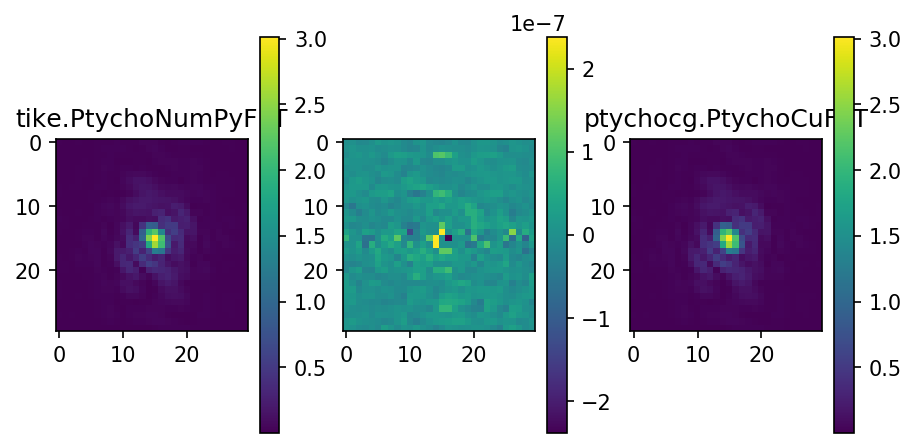

In [14]:
for i in [13*7+7]: #range(13*7, 13*7+3):

    n = xp.fft.fftshift(xp.sqrt(xp.square(xp.abs(t1[0, i, :, :]))))
    c = xp.fft.fftshift(xp.sqrt(xp.square(xp.abs(t2[0, i, :, :]))))
    d = c - n
    
    plt.figure(dpi=150, figsize=(7,3.5))
    plt.subplot(1, 3, 1)
    plt.title("tike.PtychoNumPyFFT")
    plt.imshow(n)
    plt.colorbar()    

    plt.subplot(1, 3, 2)
    plt.imshow(d)
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("ptychocg.PtychoCuFFT")
    plt.imshow(c)
    plt.colorbar()

    plt.subplots_adjust()
    plt.show()

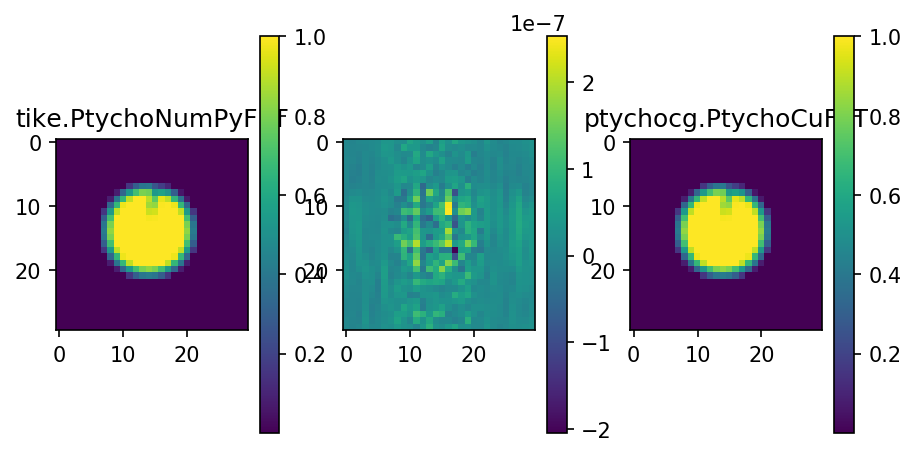

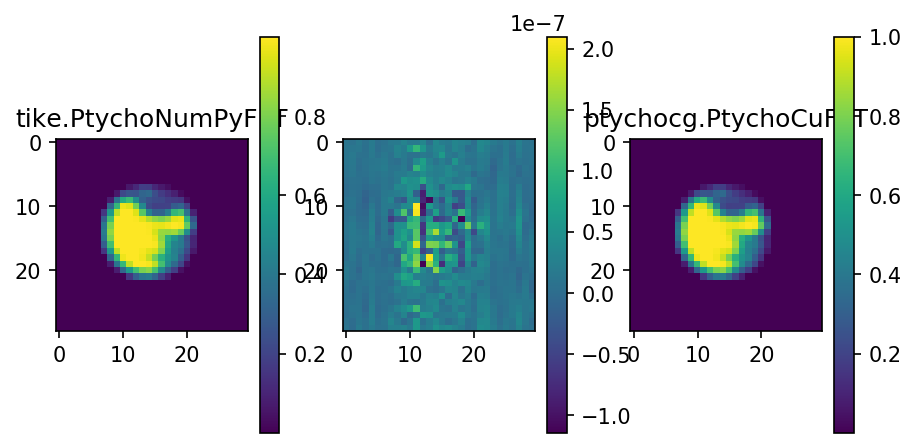

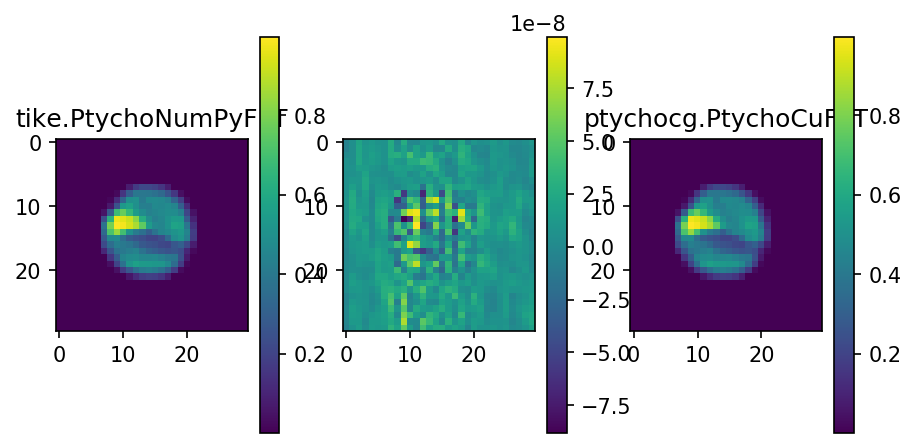

In [15]:
for i in range(13*7, 13*7+3):

    n = xp.abs(xp.fft.ifft2(t1[0, i, :, :], norm='ortho'))
    c = xp.abs(xp.fft.ifft2(t2[0, i, :, :], norm='ortho'))
    d = c - n
    
    plt.figure(dpi=150, figsize=(7,3.5))
    plt.subplot(1, 3, 1)
    plt.title("tike.PtychoNumPyFFT")
    plt.imshow(n)
    plt.colorbar()    

    plt.subplot(1, 3, 2)
    plt.imshow(d)
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("ptychocg.PtychoCuFFT")
    plt.imshow(c)
    plt.colorbar()

    plt.subplots_adjust()
    plt.show()

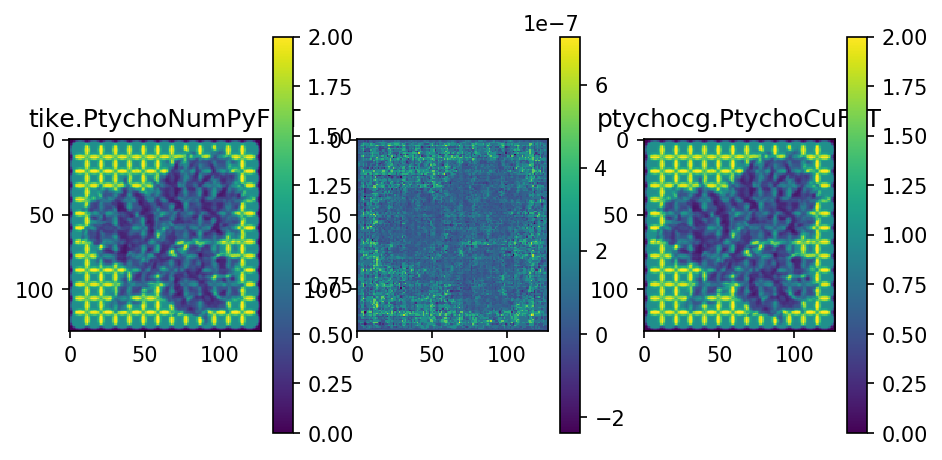

In [16]:
n = xp.abs(g1)[0]
c = xp.abs(g2)[0]
d = c - n

plt.figure(dpi=150, figsize=(7,3.5))
plt.subplot(1, 3, 1)
plt.title("tike.PtychoNumPyFFT")
plt.imshow(n)
plt.colorbar()    

plt.subplot(1, 3, 2)
plt.imshow(d)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("ptychocg.PtychoCuFFT")
plt.imshow(c)
plt.colorbar()

plt.subplots_adjust()
plt.show()

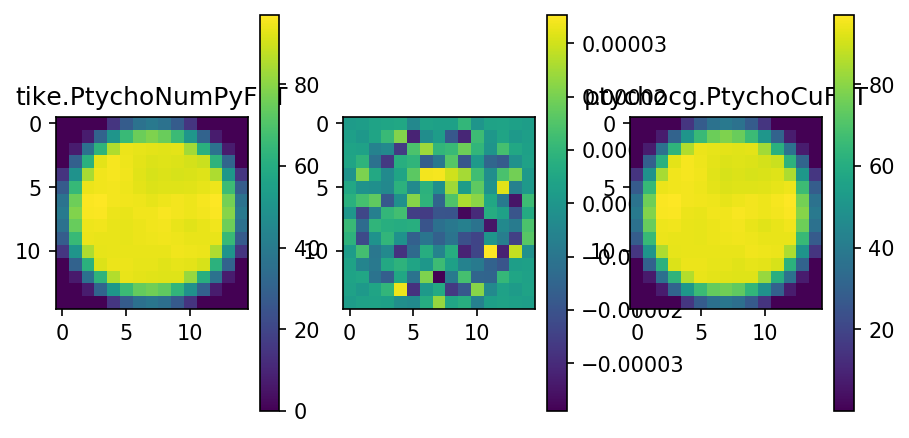

In [17]:
n = xp.abs(p1)[0]
c = xp.abs(p2)[0]
d = c - n

plt.figure(dpi=150, figsize=(7,3.5))
plt.subplot(1, 3, 1)
plt.title("tike.PtychoNumPyFFT")
plt.imshow(n)
plt.colorbar()    

plt.subplot(1, 3, 2)
plt.imshow(d)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("ptychocg.PtychoCuFFT")
plt.imshow(c)
plt.colorbar()

plt.subplots_adjust()
plt.show()